# Image Classification using Convolutional Neural Networks

## Necessary imports and helper functions.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
import tarfile
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
from tensorflow.keras.models import model_from_json
import time

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def list_subdirectories(path):
    subdirectories = [d for d in os.listdir(path)]
    return subdirectories

In [3]:
def imshow(img):
    plt.imshow(img)
    plt.show()

## Data downloading and loading

The data that we have used in this project is available in the repository. The dataset was derived from [here](https://data.caltech.edu/records/mzrjq-6wc02). This dataset contains images of 101 different classes. The images are derived from different sources and they are placed into seperate folders dependent on the class name. Classes do not have equal amounts of data. The downloaded dataset is present in the a relative path to this notebook ".\data\101_ObjectCategories".

We have split this process into two seperate cells not to download the data each time. First cell downloads and unpacks the data, while the second one reads each image into the notebook as well as their labels.

In [4]:
def downloadData(link, extract_folder="data"):
    if not os.path.exists(extract_folder):
        os.makedirs(extract_folder)

    try:
        response = requests.get(link)
        response.raise_for_status()

        temp_file_path = "temp_dataset.zip"
        with open(temp_file_path, "wb") as temp_file:
            temp_file.write(response.content)
            
        with ZipFile(temp_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        
        inner_tar_path = os.path.join(extract_folder, "caltech-101", "101_ObjectCategories.tar.gz")
        with tarfile.open(inner_tar_path, 'r:gz') as inner_tar_ref:
            test_folder = os.path.join(extract_folder)
            inner_tar_ref.extractall(test_folder)

        os.remove(inner_tar_path)
        os.remove(temp_file_path)
        shutil.rmtree(os.path.join(extract_folder, "caltech-101"))
        shutil.rmtree(os.path.join(extract_folder, "__MACOSX"))
        
    except Exception as e:
        print(f"Error: {e}")

            
# downloadData("https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1")

In [5]:
def datasetLoading(datasetPath):    
    labels = list_subdirectories(datasetPath)

    data_x = []
    data_y = []
    for label in labels:
        label_path = os.path.join(datasetPath, label)
        image_paths = list_subdirectories(label_path)

        for image_path in image_paths:
            img = cv2.imread(os.path.join(label_path, image_path))
            data_x.append(img)
            data_y.append(label)

    data_y = np.array(data_y)
    return data_x, data_y


path_to_load = r".\data\101_ObjectCategories"
data_x, data_y = datasetLoading(path_to_load)

### Verification

Shape of the first image in the dataset = (300, 260, 3). This image is labeled as accordion.


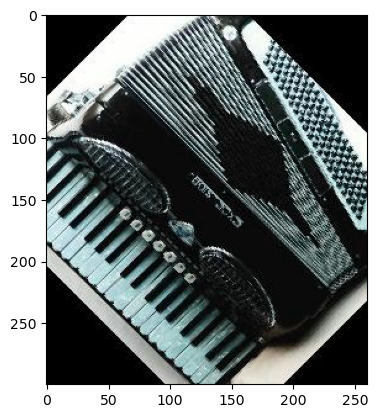

In [6]:
print(f'Shape of the first image in the dataset = {data_x[0].shape}. This image is labeled as {data_y[0]}.')
imshow(data_x[0])

## Data Preprocessing

### Unifying the size of images and converting them into np.array

In [7]:
data_x = np.array([cv2.resize(data_x[i], (64, 64)) for i in range(len(data_x))])

### Unifying the number and sequence of channels

First let us check if the number of channels differs in any picture.

In [8]:
print(np.unique(np.array([data_x[i].shape[2] for i in range(len(data_x))])))

[3]


We can see that each image has 3 number of channels. Meaning that all of them are represented by BGR, as it is a standard format of imread function in cv2. Thus we will convert the sequence of all images from BGR to RGB as asked. We also save the image for further verification, as data_x will be changed.

In [9]:
data_x = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in data_x])
verification2 = data_x[0].copy()

## Division of dataset into training and testing

### Class removal.
After looking at the data we have decided to remove two classes: 

* BACKGROUND_Google - as it seems to present completely random elements,
* Faces_easy - as it presents pretty much the same elements as Faces class.

There might be some more classes that should be removed, but they will not be considered, as they do not have enough images to be taken into further analysis. (We have chosen the first 20 classes with the biggest amount of images except the two classes mentioned above.)

In [10]:
def removeClasses(class_name, data_x, data_y):
    indices = np.where(data_y == class_name)[0]
    data_x = np.delete(data_x, indices, axis=0)
    data_y = np.delete(data_y, indices, axis=0)
    return data_x, data_y


class_name = "BACKGROUND_Google"
data_x, data_y = removeClasses(class_name, data_x, data_y)
class_name = "Faces_easy"
data_x, data_y = removeClasses(class_name,  data_x, data_y)
data_x_part2 = data_x.copy()
data_y_part2 = data_y.copy()

### Finding the classes to be considered.

First we find the top 20 classes in terms of the number of images that they contain.

In [11]:
def findClasses(data_y, num_classes=20):    
    unique_labels, label_counts = np.unique(data_y, return_counts=True)
    sorted_indices = np.argsort(label_counts)[::-1]
    max_examples = label_counts[sorted_indices[num_classes - 1]]
    return unique_labels, label_counts, sorted_indices, max_examples


unique_labels, label_counts, sorted_indices, max_examples = findClasses(data_y)
for i in range(20):
    index = sorted_indices[i]
    print(f'Class {unique_labels[index]} contains {label_counts[index]} examples.')
unique_labels_part2 = unique_labels.copy()
label_counts_part2 = label_counts.copy()
sorted_indices_part2 = sorted_indices.copy()
max_examples_part2 = max_examples.copy() 

Class airplanes contains 800 examples.
Class Motorbikes contains 798 examples.
Class Faces contains 435 examples.
Class watch contains 239 examples.
Class Leopards contains 200 examples.
Class bonsai contains 128 examples.
Class car_side contains 123 examples.
Class ketch contains 114 examples.
Class chandelier contains 107 examples.
Class hawksbill contains 100 examples.
Class grand_piano contains 99 examples.
Class brain contains 98 examples.
Class butterfly contains 91 examples.
Class helicopter contains 88 examples.
Class menorah contains 87 examples.
Class starfish contains 86 examples.
Class trilobite contains 86 examples.
Class kangaroo contains 86 examples.
Class ewer contains 85 examples.
Class sunflower contains 85 examples.


Then we remove any classes that are not in these classes from datasets.

In [12]:
def removeClassesNotInList(unique_labels, sorted_indices, data_x, data_y, num_classes=20):    
    top20_labels = unique_labels[sorted_indices[:num_classes]]
    top20_indices = np.where(np.isin(data_y, top20_labels))[0]
    data_x = data_x[top20_indices]
    data_y = data_y[top20_indices]
    return data_x, data_y


data_x, data_y = removeClassesNotInList(unique_labels, sorted_indices, data_x, data_y)

For the model to work comparably well for any class, we need to make each class that we consider have the same amount of data. 

In [13]:
def cappingClassSize(unique_labels, label_counts, sorted_indices, max_examples, data_x, data_y, num_classes=20):    
    for i in range(num_classes):
        difference = label_counts[sorted_indices[i]] - max_examples
        if difference > 0:
            top20_indices = np.where(data_y == unique_labels[sorted_indices[i]])[0]
            top20_indices = top20_indices[:difference]
            data_x = np.delete(data_x, top20_indices, axis=0)
            data_y = np.delete(data_y, top20_indices, axis=0)
    return data_x, data_y


data_x, data_y = cappingClassSize(unique_labels, label_counts, sorted_indices, max_examples, data_x, data_y)
unique_labels, label_counts = np.unique(data_y, return_counts=True)
sorted_indices = np.argsort(label_counts)[::-1]
for i in range(20):
        index = sorted_indices[i]
        print(f'Class {unique_labels[index]} contains {label_counts[index]} examples.')

Class watch contains 85 examples.
Class trilobite contains 85 examples.
Class Leopards contains 85 examples.
Class Motorbikes contains 85 examples.
Class airplanes contains 85 examples.
Class bonsai contains 85 examples.
Class brain contains 85 examples.
Class butterfly contains 85 examples.
Class car_side contains 85 examples.
Class chandelier contains 85 examples.
Class ewer contains 85 examples.
Class grand_piano contains 85 examples.
Class hawksbill contains 85 examples.
Class helicopter contains 85 examples.
Class kangaroo contains 85 examples.
Class ketch contains 85 examples.
Class menorah contains 85 examples.
Class starfish contains 85 examples.
Class sunflower contains 85 examples.
Class Faces contains 85 examples.


### Split the data into train and test sets while maintaining the class proportions.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.7, test_size=0.3, stratify=data_y, random_state=24)

### Perform one-hot encodig on y vectors and transform all sets to numpy array.

To perform one-hot encoding first we transform the strings of class names into integers, and then perform one-hot encoding.

In [15]:
def oneHotEncoding(X_train, X_test, y_train, y_test, num_classes=20):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = label_encoder.transform(y_test)
    y_test = to_categorical(y_test, num_classes=num_classes)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    return X_train, X_test, y_train, y_test, label_encoder


X_train, X_test, y_train, y_test, label_encoder = oneHotEncoding(X_train, X_test, y_train, y_test)

### Verification.

First we check the shape of the X_train, X_test and the y_train, y_test. The X_train is 70% of the whole dataset, while the X_test is 30%. Also we can see that the dimensions of y match the dimensions of x. Additionally, we can see that one-hot encoding worked, as each element of y has 20 columns, which represent the amount of classes.

In [16]:
print(f"Shape of X_train = {X_train.shape}, X_test = {X_test.shape}, y_train = {y_train.shape}, y_test = {y_test.shape}")

Shape of X_train = (1190, 64, 64, 3), X_test = (510, 64, 64, 3), y_train = (1190, 20), y_test = (510, 20)


Now we check sample images from both train (2 images from the left) and test set (2 images from the right) along with their labels for all the classes.

Examples of class Faces


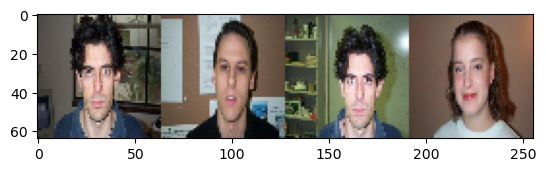

Examples of class Leopards


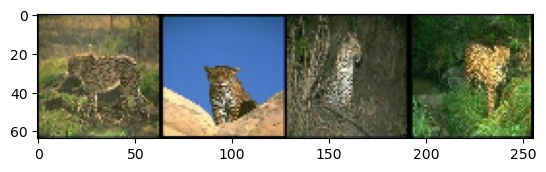

Examples of class Motorbikes


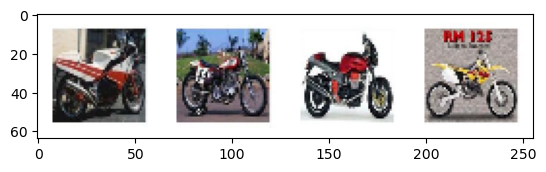

Examples of class airplanes


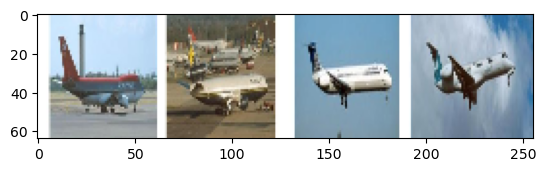

Examples of class bonsai


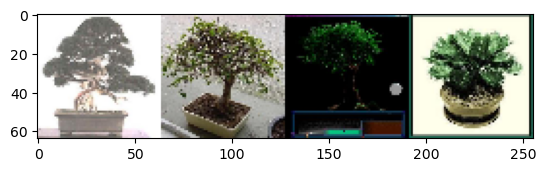

Examples of class brain


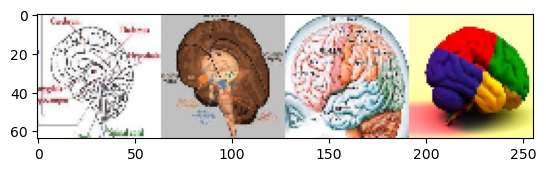

Examples of class butterfly


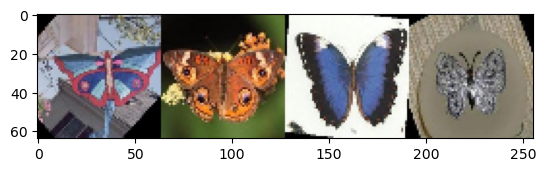

Examples of class car_side


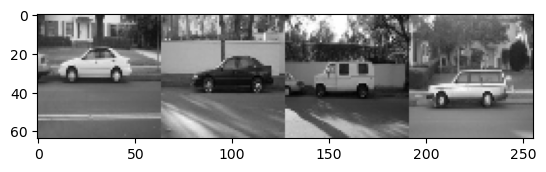

Examples of class chandelier


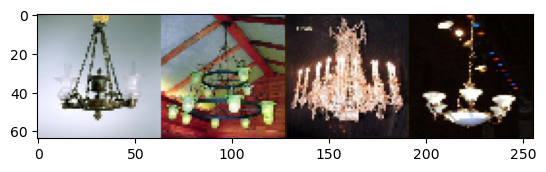

Examples of class ewer


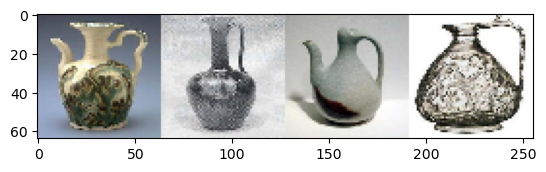

Examples of class grand_piano


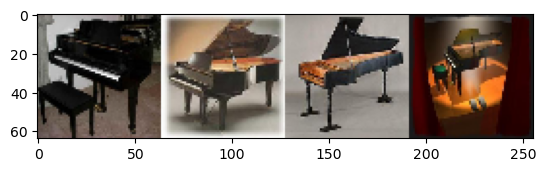

Examples of class hawksbill


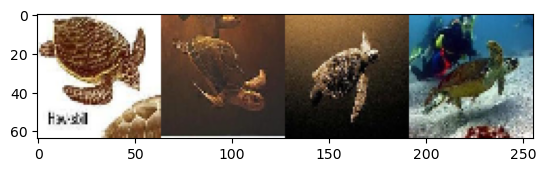

Examples of class helicopter


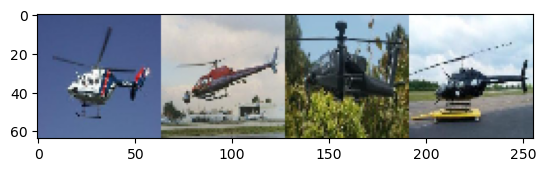

Examples of class kangaroo


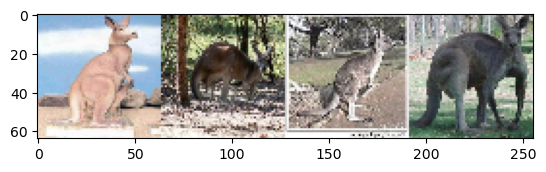

Examples of class ketch


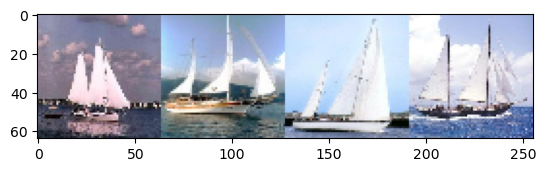

Examples of class menorah


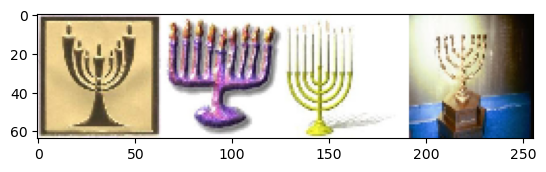

Examples of class starfish


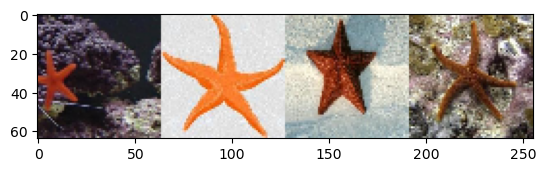

Examples of class sunflower


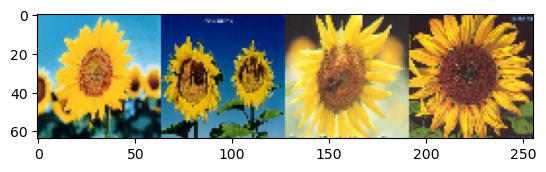

Examples of class trilobite


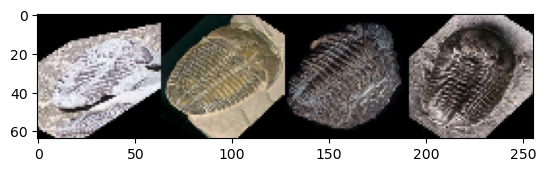

Examples of class watch


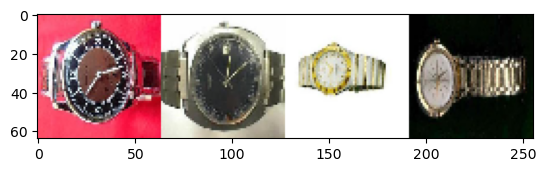

In [17]:
for i in range(20):
    indices_of_class_train = np.where(y_train[:, i] == 1)[0]
    indices_of_class_test = np.where(y_test[:, i] == 1)[0]
    print(f"Examples of class {label_encoder.classes_[i]}")
    imshow(np.concatenate([X_train[indices_of_class_train[0]], X_train[indices_of_class_train[1]], X_test[indices_of_class_test[0]], X_test[indices_of_class_test[1]]], 1))

Now we check how many samples are there in both train and test sets, and check if their proportions are more or less the same in both subsets (we allow the difference to be at most 0.01, as not all numbers can be divided into percentages perfectly).

In [18]:
_, label_counts_ver = np.unique(y_train, return_counts=True, axis=0)
proportions_train = np.round(label_counts_ver / len(y_train), 5)
print("Class distribution over the whole train set")
print(label_counts_ver)
print("Class proportion over the whole train set")
print(proportions_train)
_, label_counts_ver = np.unique(y_test, return_counts=True, axis=0)
proportions_test = np.round(label_counts_ver / len(y_test), 5)
print("Class distribution over the whole test set")
print(label_counts_ver)
print("Class proportion over the whole test set")
print(proportions_test)
are_proportions_equal = np.all(np.abs(proportions_train - proportions_test) < 0.01 )
print(f"Are the proportions more or less equal between datasets (allowed difference = 0.01)? = {are_proportions_equal}")

Class distribution over the whole train set
[59 59 60 60 59 60 60 59 59 60 60 60 60 60 60 59 59 59 59 59]
Class proportion over the whole train set
[0.04958 0.04958 0.05042 0.05042 0.04958 0.05042 0.05042 0.04958 0.04958
 0.05042 0.05042 0.05042 0.05042 0.05042 0.05042 0.04958 0.04958 0.04958
 0.04958 0.04958]
Class distribution over the whole test set
[26 26 25 25 26 25 25 26 26 25 25 25 25 25 25 26 26 26 26 26]
Class proportion over the whole test set
[0.05098 0.05098 0.04902 0.04902 0.05098 0.04902 0.04902 0.05098 0.05098
 0.04902 0.04902 0.04902 0.04902 0.04902 0.04902 0.05098 0.05098 0.05098
 0.05098 0.05098]
Are the proportions more or less equal between datasets (allowed difference = 0.01)? = True


## Standarization

### Performing Standarization using the ($\frac{x - \mu}{\sigma}$) formula for each channel seperately.

$\mu$ and $\sigma$ were calcultaed on the training set to avoid data leakage from the test set.

In [19]:
def standardizeImages(X_train, X_test):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    channel_means = np.mean(X_train_out, axis=(0, 1, 2))
    channel_stds = np.std(X_train_out, axis=(0, 1, 2))
    X_train_out = (X_train_out - channel_means) / channel_stds
    X_test_out = (X_test_out - channel_means) / channel_stds
    return X_train_out, X_test_out, channel_means, channel_stds


X_train, X_test, channel_means, channel_stds = standardizeImages(X_train, X_test)

### Verification

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of the first image in the dataset = (64, 64, 3).


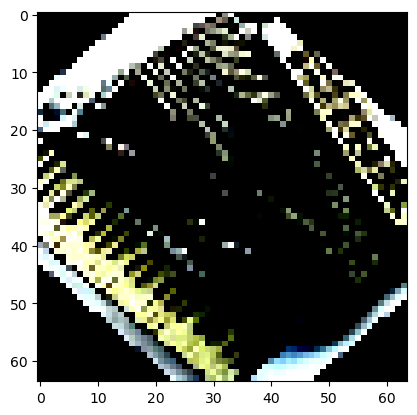

In [20]:
verification2 = (verification2 - channel_means) / channel_stds
print(f'Shape of the first image in the dataset = {verification2.shape}.')
imshow(verification2)

## Model definition

In [21]:
def createModel(input_shape, num_classes):
    model = Sequential()
    # Conv block 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Conv block 2
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Conv block 3
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Flattening
    model.add(Flatten())
    # Fully connected layer 1
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Fully connected layer 2
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


input_shape = (64, 64, 3)
num_classes = 20
model = createModel(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

### Verification - model compilation.

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model.

Adding early stopping condition.

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

Fitting the model to the train set, while monitoring the values of accuracy on the test set (marked as val_accuracy).

In [24]:
model_values = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/250
38/38 [==============================] - 5s 15ms/step - loss: 3.3255 - accuracy: 0.1723 - val_loss: 3.0813 - val_accuracy: 0.1588
Epoch 2/250
38/38 [==============================] - 0s 9ms/step - loss: 2.3080 - accuracy: 0.3731 - val_loss: 5.1088 - val_accuracy: 0.0667
Epoch 3/250
38/38 [==============================] - 0s 8ms/step - loss: 1.7848 - accuracy: 0.4815 - val_loss: 6.3664 - val_accuracy: 0.1020
Epoch 4/250
38/38 [==============================] - 0s 8ms/step - loss: 1.5001 - accuracy: 0.5597 - val_loss: 4.5161 - val_accuracy: 0.1588
Epoch 5/250
38/38 [==============================] - 0s 8ms/step - loss: 1.3646 - accuracy: 0.6076 - val_loss: 4.7547 - val_accuracy: 0.1176
Epoch 6/250
38/38 [==============================] - 0s 8ms/step - loss: 1.2222 - accuracy: 0.6504 - val_loss: 2.4600 - val_accuracy: 0.3353
Epoch 7/250
38/38 [==============================] - 0s 8ms/step - loss: 0.9869 - accuracy: 0.6950 - val_loss: 1.8711 - val_accuracy: 0.4706
Epoch 8/250


### Verification

Presenting the learning curves.

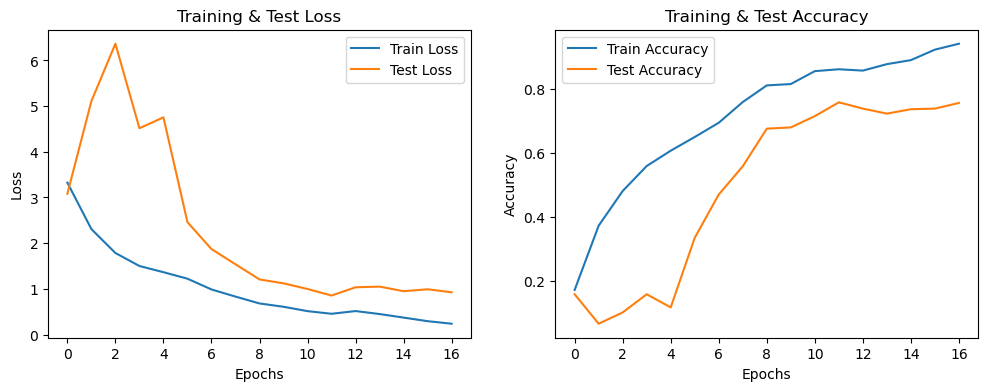

In [25]:
def plotLearningCurves(model_values):    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Train Loss')
    plt.plot(model_values.history['val_loss'], label='Test Loss')
    plt.title('Training & Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model_values.history['accuracy'], label='Train Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Test Accuracy')
    plt.title('Training & Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


plotLearningCurves(model_values)

Predicting the values of the test set.

In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Creating a confusion matrix.

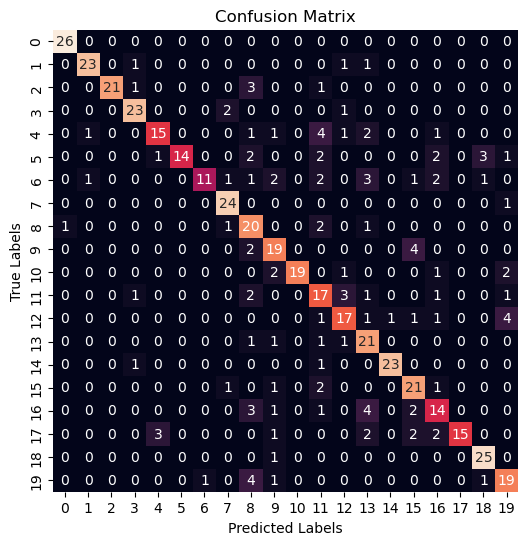

In [27]:
def confusionMatrix(y_true_classes, y_pred_classes):
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    return conf_matrix


conf_matrix = confusionMatrix(y_true_classes, y_pred_classes)

Calculating precision and recall scores. Additonally, visualizing them.

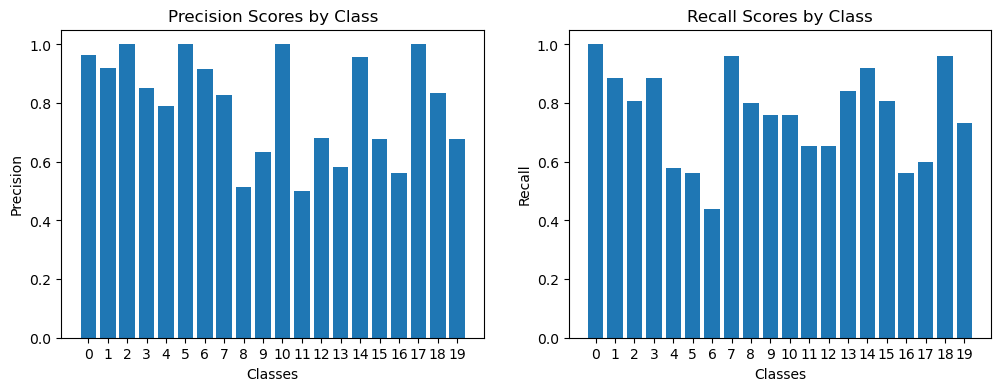

In [28]:
def precisionRecall(y_true_classes, y_pred_classes):
    precision_scores = precision_score(y_true_classes, y_pred_classes, average=None)
    recall_scores = recall_score(y_true_classes, y_pred_classes, average=None)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(precision_scores)), precision_scores)
    plt.xticks(range(len(precision_scores)), labels=[f'{i}' for i in range(len(precision_scores))])
    plt.title('Precision Scores by Class')
    plt.xlabel('Classes')
    plt.ylabel('Precision')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(recall_scores)), recall_scores)
    plt.xticks(range(len(recall_scores)), labels=[f'{i}' for i in range(len(recall_scores))])
    plt.title('Recall Scores by Class')
    plt.xlabel('Classes')
    plt.ylabel('Recall')

    plt.show()
    

precisionRecall(y_true_classes, y_pred_classes)

Showing a few images from the test set along with the probabilities of class assignment. The first image is correctly classified, while the second image is not.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image classified correctly:


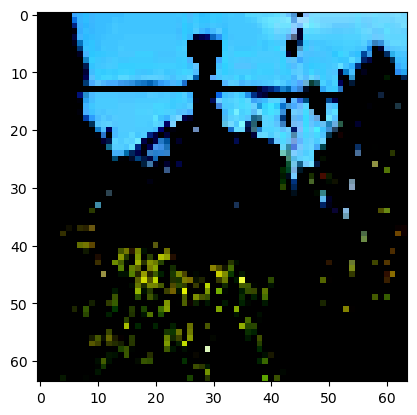

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted = 12, True = 12
For class 0 probability = 0.00017
For class 1 probability = 0.00229
For class 2 probability = 0.00017
For class 3 probability = 0.00379
For class 4 probability = 0.00760
For class 5 probability = 0.00012
For class 6 probability = 0.02128
For class 7 probability = 0.00142
For class 8 probability = 0.00048
For class 9 probability = 0.00285
For class 10 probability = 0.00066
For class 11 probability = 0.16808
For class 12 probability = 0.76000
For class 13 probability = 0.01141
For class 14 probability = 0.00218
For class 15 probability = 0.00090
For class 16 probability = 0.00664
For class 17 probability = 0.00397
For class 18 probability = 0.00151
For class 19 probability = 0.00451

Image classified incorrectly:


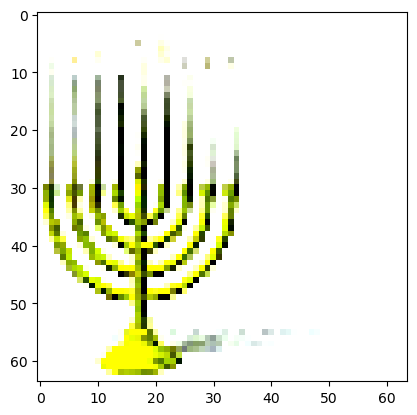

Predicted = 16, True = 15
For class 0 probability = 0.00214
For class 1 probability = 0.00015
For class 2 probability = 0.00467
For class 3 probability = 0.00792
For class 4 probability = 0.00007
For class 5 probability = 0.00183
For class 6 probability = 0.00056
For class 7 probability = 0.00163
For class 8 probability = 0.25078
For class 9 probability = 0.00052
For class 10 probability = 0.00049
For class 11 probability = 0.00088
For class 12 probability = 0.00986
For class 13 probability = 0.00122
For class 14 probability = 0.00584
For class 15 probability = 0.00287
For class 16 probability = 0.67859
For class 17 probability = 0.00022
For class 18 probability = 0.00025
For class 19 probability = 0.02950


In [29]:
def plotImageExamples(index):
    img = X_test[index]
    imshow(img)

    expanded = np.expand_dims(img, axis=0)
    
    predicted = model.predict(expanded, verbose=0)[0]
    true_label = np.argmax(y_test[index])

    print(f"Predicted = {np.argmax(predicted)}, True = {true_label}")

    predicted = predicted / np.sum(predicted)
    for i in range(len(predicted)):
        print(f"For class {i} probability = {format(predicted[i], '.5f')}")
    


print("Image classified correctly:")
correctly_classified_indices = np.where(y_pred_classes == y_true_classes)[0]
plotImageExamples(correctly_classified_indices[0])

print("\nImage classified incorrectly:")
incorrectly_classified_indices = np.where(y_pred_classes != y_true_classes)[0]
plotImageExamples(incorrectly_classified_indices[0])

Other visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Most commonly mistaken classes
True label = 19 (watch), Predicted label = 8 (chandelier)


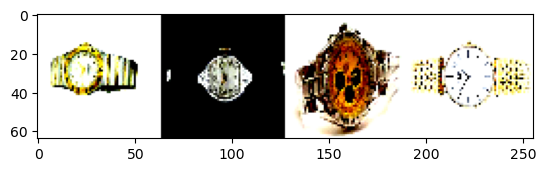

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images of given true label for example from true class


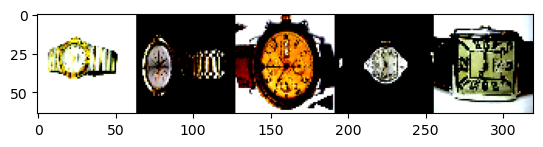

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images of given predicted label for example from true class


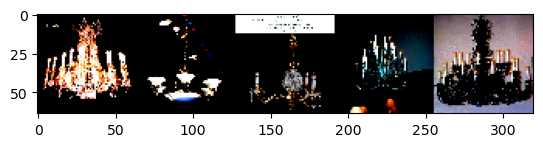

Mostly mistaken class = 6


In [30]:
vis_conf_matrix = conf_matrix.copy()
vis_conf_matrix = np.array([[vis_conf_matrix[i, j] if i != j else 0 for i in range(vis_conf_matrix.shape[0])] for j in range(vis_conf_matrix.shape[0])])
max_indices = np.unravel_index(np.argmax(vis_conf_matrix, axis=None), vis_conf_matrix.shape)
misclassified_indices = np.where((y_true_classes == max_indices[1]) & (y_pred_classes == max_indices[0]))[0]
print("Most commonly mistaken classes")
print(f"True label = {max_indices[1]} ({label_encoder.classes_[max_indices[1]]}), Predicted label = {max_indices[0]} ({label_encoder.classes_[max_indices[0]]})")
imshow(np.concatenate([X_test[index] for index in misclassified_indices], 1))

misclassified_indices = np.where((y_true_classes == max_indices[1]))[0]
print("Images of given true label for example from true class")
imshow(np.concatenate([X_test[index] for index in misclassified_indices[:5]], 1))

misclassified_indices = np.where((y_true_classes == max_indices[0]))[0]
print("Images of given predicted label for example from true class")
imshow(np.concatenate([X_test[index] for index in misclassified_indices[:5]], 1))

vis_conf_matrix = conf_matrix.copy()
vis_conf_matrix = np.array([[vis_conf_matrix[i, j] if i == j else np.inf for i in range(vis_conf_matrix.shape[0])] for j in range(vis_conf_matrix.shape[0])])
min_indices = np.unravel_index(np.argmin(vis_conf_matrix, axis=None), vis_conf_matrix.shape)
print(f"Mostly mistaken class = {min_indices[0]}")

## Saving and loading the model

Saving the model as well as its weights.

In [31]:
def saveModel(model, model_json_path, model_weights_path):
    model_json = model.to_json()
    with open(model_json_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_weights_path)

Loading the model as well as its weights.

In [32]:
def loadModel(model_path, model_weights_path):
    with open(model_path, "r") as json_file:
        loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_path)
    return loaded_model

### Verification

First we save the model.

In [33]:
saveModel(model, 'model.json', 'model_weights.h5')

Then we load the model.

In [34]:
loaded_model = loadModel("model.json", "model_weights.h5")

Now we predict the values by the loaded model again.

In [35]:
loaded_model_predictions = loaded_model.predict(X_test)

Now we compare the confusion matrix of our model, to the loaded model.

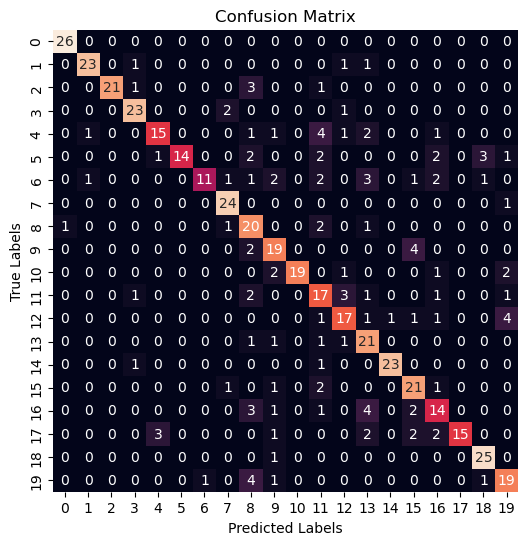

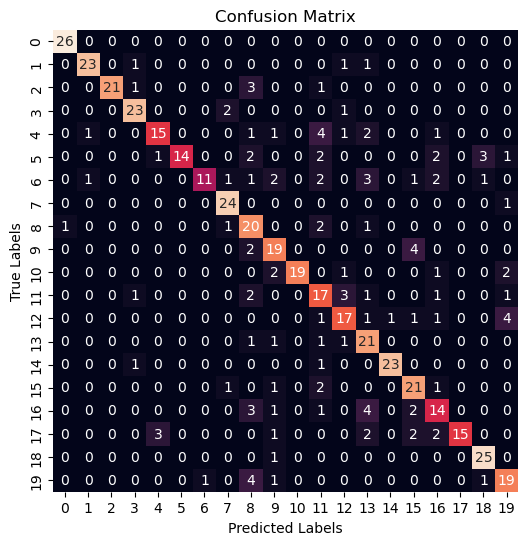

In [36]:
conf_matrix = confusionMatrix(y_true_classes, y_pred_classes)

y_loaded_pred_classes = np.argmax(loaded_model_predictions, axis=1)
conf_matrix = confusionMatrix(y_true_classes, y_loaded_pred_classes)

We can see that these confusion matrices are exactly the same, thus the saving and loading worked properly.

## Summary

**Results without the dropout layer** 

We can see that the model performs relatively well for given number of pictures and classes. The model had to learn from the training set that consisted of 59 pictures of each class and then classify 26 pictures of the test set from each class. If we were to present the average loss/accuracy of the model over 10 runs for example (this is also visible on the current graph from just one iteration, but small fluctuations occur, thus averaging the loss and accuracy over a couple of runs would make it easier to see) we would be able to deduce that the model could be stopped just after about 12 epochs, as after that a small overfitting can be noticed (or no change in test accuracy and loss at all).  What is also important to note is that the model in reality does not output just a single label for the image, thus after looking at the probabilities of an incorrectly classified image presented in the verification of step 5, we can see that the model almost always presents the actual result in top 3 of the probabilities. Therefore, instead of giving the exact label of the image we could present top 3 most possible ones, and the model would have accuracy on the test set pretty close to 100%. As for now the model achieves accuracies between 73-82% on the test set (again we have run this jupyter notebook a couple of times just to see the results).

**Overfitting/ underfitting**

Currently the model overfits the training set. Despite that, it does not reallly cause too big differences in the accuracy/loss of the model, as an Early Stopping condition is applied. This could be improved by a few possible solutions:
* attaching droput layers to the fully connected layers. That would cause the model to not achieve accuracies close to 100% on the train set but it would the results slightly on the test set, thus removing overfitting. 
* change of the train/test split or generally more data for the model to train. The number of classes, number of examples per each class and the train/test split value are crucial to the model accuracies and loss for previously unseen data. For given number of classes, surprisingly, a number of examples required per each class can be found that would allow the model to overfit less. In part 2 we further dwelve into this issue.
* changing the Early Stopping patience to lower number. Currently it is set to 5, it perhaps could be lower.
* Adding BatchNormalization layer after dense layers. It again can slightly reduce overfitting and allow the algorithm to perform better on test set.

**Additional improvements**

We have tested the model with additional Dropout and BatchNormalization layers near each dense layer (with rate parameter set to 0.5), it seemed to improve the results for the test set, while worsening the results for the train set (currently in the notebook the model with Dropout and BatchNormalization layers is presented alongside its results). It also pretty much removed the issue of overfitting, as the model loss and accuracy values seemed to converge to a given point and after the early stopping condition was met the model was stopped. Now the model achieved around 78-84% accuracy.

## Additional considerations

### The impact of the size of the training set on the results
- Compare the results achieved by the same model, e.g. for 20 classes that have 85 samples and 20 classes that have 30 samples

First we need to create seperate data for the 30 samples case, as we have previously tested the model on 85 samples already.

In [37]:
data_x_30, data_y_30 = removeClassesNotInList(unique_labels_part2, sorted_indices_part2, data_x_part2, data_y_part2)
data_x_30, data_y_30 = cappingClassSize(unique_labels_part2, label_counts_part2, sorted_indices_part2, 30, data_x_30, data_y_30)

X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(data_x_30, data_y_30, train_size=0.7, test_size=0.3, stratify=data_y_30, random_state=24)
X_train_30, X_test_30, y_train_30, y_test_30, label_encoder_30 = oneHotEncoding(X_train_30, X_test_30, y_train_30, y_test_30)

X_train_30, X_test_30, channel_means, channel_stds = standardizeImages(X_train_30, X_test_30)

Now let us train and test the previous model on new data with only 30 samples of each class.

In [38]:
model_part2_task1 = createModel((64,64,3), 20)
model_part2_task1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_values_part2_task1 = model_part2_task1.fit(X_train_30, y_train_30, epochs=250, batch_size=32, validation_data=(X_test_30, y_test_30), callbacks=[early_stopping])

Epoch 1/250
14/14 [==============================] - 1s 48ms/step - loss: 3.7979 - accuracy: 0.1048 - val_loss: 2.7243 - val_accuracy: 0.2333
Epoch 2/250
14/14 [==============================] - 0s 9ms/step - loss: 2.8212 - accuracy: 0.2405 - val_loss: 2.8033 - val_accuracy: 0.1778
Epoch 3/250
14/14 [==============================] - 0s 10ms/step - loss: 2.3420 - accuracy: 0.3524 - val_loss: 3.2797 - val_accuracy: 0.0778
Epoch 4/250
14/14 [==============================] - 0s 9ms/step - loss: 2.0931 - accuracy: 0.4143 - val_loss: 3.4839 - val_accuracy: 0.1167
Epoch 5/250
14/14 [==============================] - 0s 9ms/step - loss: 2.0105 - accuracy: 0.4095 - val_loss: 3.7609 - val_accuracy: 0.0778
Epoch 6/250
14/14 [==============================] - 0s 9ms/step - loss: 1.8064 - accuracy: 0.4952 - val_loss: 4.0825 - val_accuracy: 0.0611


After the model has been trained we can see the graphs and compare them to the original model.

Model trained and tested on 85 samples from each class.


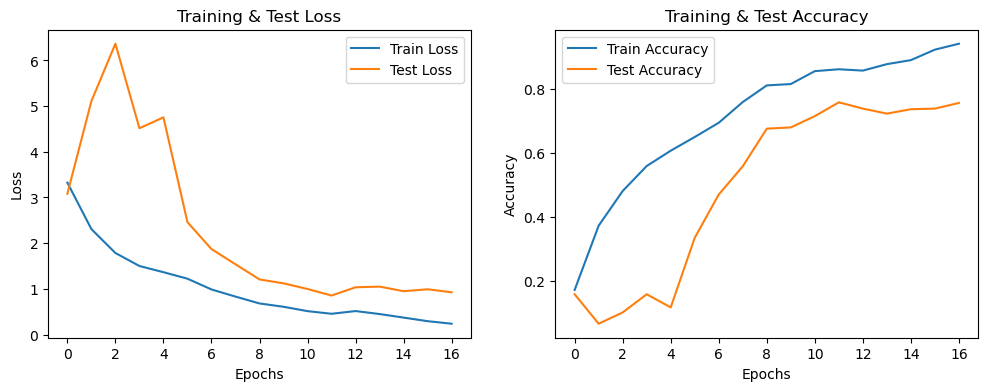

Model trained and tested on 30 samples from each class.


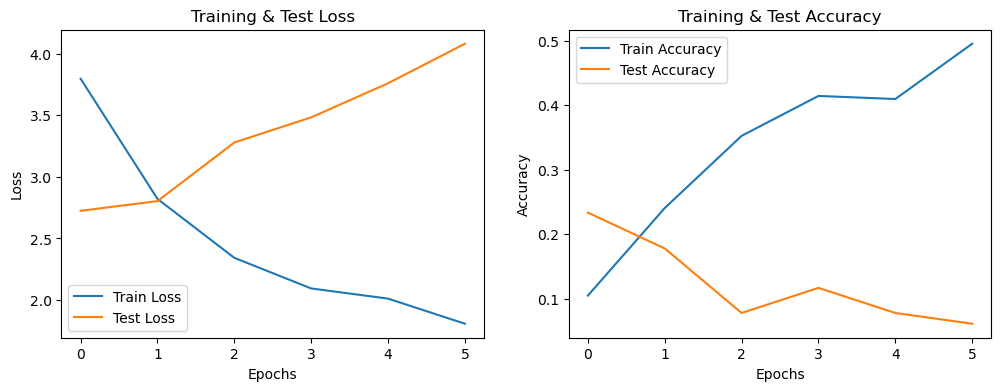

In [39]:
print("Model trained and tested on 85 samples from each class.")
plotLearningCurves(model_values)
print("Model trained and tested on 30 samples from each class.")
plotLearningCurves(model_values_part2_task1)

Now let us also see the confusion matrices.

Model trained and tested on 85 samples from each class.


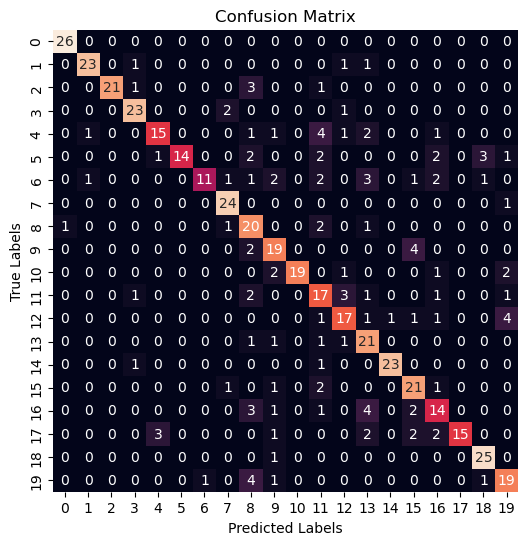

Model trained and tested on 30 samples from each class.


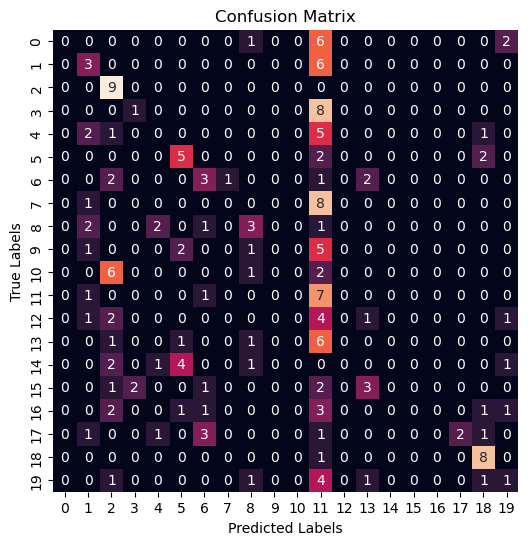

In [40]:
print("Model trained and tested on 85 samples from each class.")
conf_matrix = confusionMatrix(y_true_classes, y_pred_classes)
y_pred_part2_task1 = model_part2_task1.predict(X_test_30, verbose=0)
y_pred_classes_part2_task1 = np.argmax(y_pred_part2_task1, axis=1)
y_true_classes_part2_task1 = np.argmax(y_test_30, axis=1)
print("Model trained and tested on 30 samples from each class.")
conf_matrix = confusionMatrix(y_true_classes_part2_task1, y_pred_classes_part2_task1)

Now let us see precision and recall statistics.

Model trained and tested on 85 samples from each class.


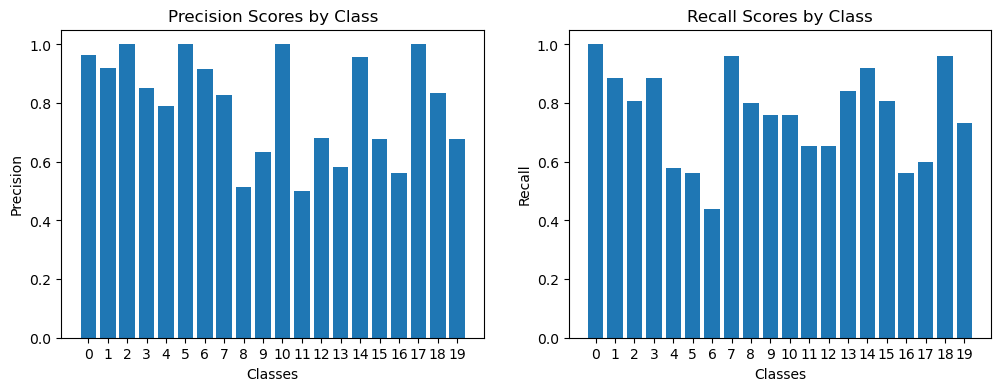

Model trained and tested on 30 samples from each class.


d:\Environment\anaconda\envs\deepmachinelearning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


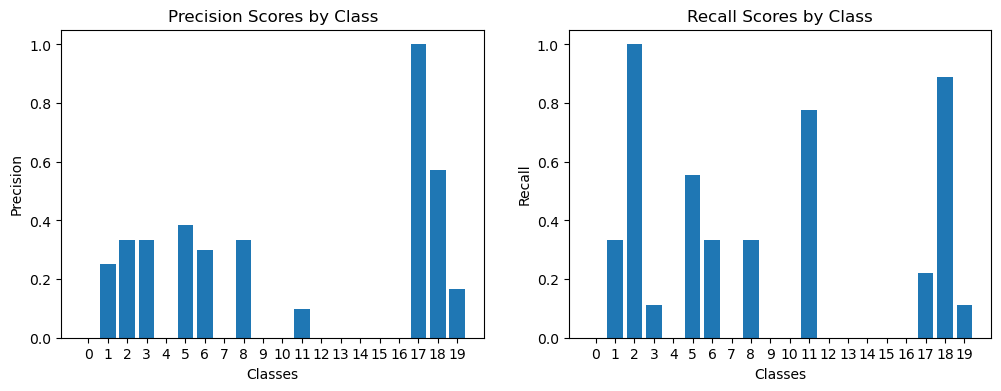

In [41]:
print("Model trained and tested on 85 samples from each class.")
precisionRecall(y_true_classes, y_pred_classes)
print("Model trained and tested on 30 samples from each class.")
precisionRecall(y_true_classes_part2_task1, y_pred_classes_part2_task1)

We can clearly see that the model performs extremely poorly on such a small amount of data. That is because the model learns a small portion of data with small variety, thus making it diffuclt to work for cases outside of the training set (overfitting). That is very well visible on the train/test loss and accuracy graphs. Although, the model performs poorly on training set, it most likely would have learned it perfectly if it was not for the EarlyStopping that stopped the model from training just after the 6 epoch (with patience = 5), meaning that the model was not learning anything useful for cases outside the training set. Additionally, even if the model was not stopped by the Early Stopping it still would have most likely performed poorly on the test set, as overfitting would appear. 

On the other hand model with 85 samples from each class was able to learn quite well and was stopped after much more epochs. That means that the model was not only able to classify training set examples well, but also it learned from data that varied enough to be applied to cases in the test set. 

To sum up, the model with such a large number of classes and contrary, such a small number of samples, is doomed to perform poorly, as simply the model is unable to learn enough to be able to classify previously unseen examples well with such a large number of classes.

### The impact of the number of decision classes on the results

For this task we will compare the results of the same model, based on different number of classes (10, 20, 30, 50).

In [42]:
task2_models_values = []
task2_pred_values = []
task2_true_values = []
for num_classes in [10, 20, 30, 50]:
    unique_labels_part2_task2, label_counts_part2_task2, sorted_indices_part2_task2, max_examples_part2_task2 = findClasses(data_y_part2,num_classes)
    data_x_task2, data_y_task2 = removeClassesNotInList(unique_labels_part2_task2, sorted_indices_part2_task2, data_x_part2, data_y_part2, num_classes)
    data_x_task2, data_y_task2 = cappingClassSize(unique_labels_part2_task2, label_counts_part2_task2, sorted_indices_part2_task2, max_examples_part2_task2, data_x_task2, data_y_task2,num_classes)
    print(f"Number of samples for each of {len(np.unique(data_y_task2))} classes = {np.unique(data_y_task2, return_counts=True)[1][0]} ")

    X_train_task2, X_test_task2, y_train_task2, y_test_task2 = train_test_split(data_x_task2, data_y_task2, train_size=0.7, test_size=0.3, stratify=data_y_task2, random_state=24)
    X_train_task2, X_test_task2, y_train_task2, y_test_task2, label_encoder_task2 = oneHotEncoding(X_train_task2, X_test_task2, y_train_task2, y_test_task2, num_classes)

    X_train_task2, X_test_task2, channel_means, channel_stds = standardizeImages(X_train_task2, X_test_task2)

    model_task2 = createModel((64,64,3), num_classes)
    model_task2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    model_values_task2 = model_task2.fit(X_train_task2, y_train_task2, epochs=250, batch_size=32, validation_data=(X_test_task2, y_test_task2), callbacks=[early_stopping], verbose=0)
    y_pred_task2 = model_task2.predict(X_test_task2, verbose=0)
    y_pred_classes_task2 = np.argmax(y_pred_task2, axis=1)
    y_true_classes_task2 = np.argmax(y_test_task2, axis=1)
    task2_models_values.append(model_values_task2)
    task2_pred_values.append(y_pred_classes_task2)
    task2_true_values.append(y_true_classes_task2)

Number of samples for each of 10 classes = 100 
Number of samples for each of 20 classes = 85 
Number of samples for each of 30 classes = 73 
Number of samples for each of 50 classes = 59 


Now let us see the visualization of the results.

Model trained and tested on 100 samples from each of 10 classes.


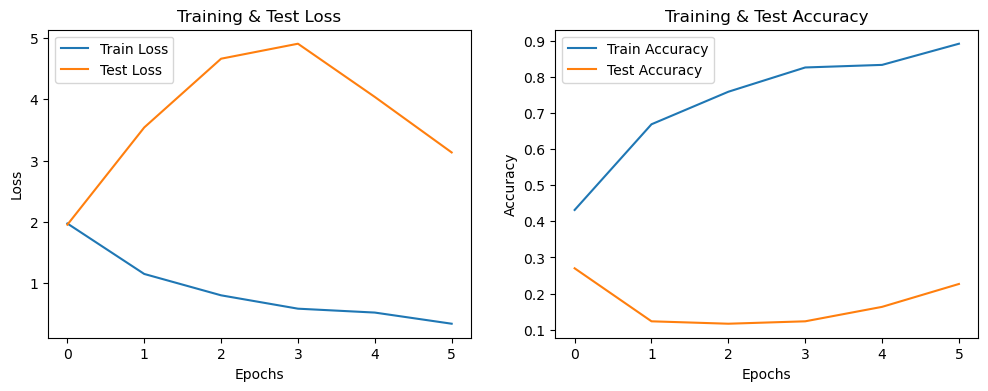

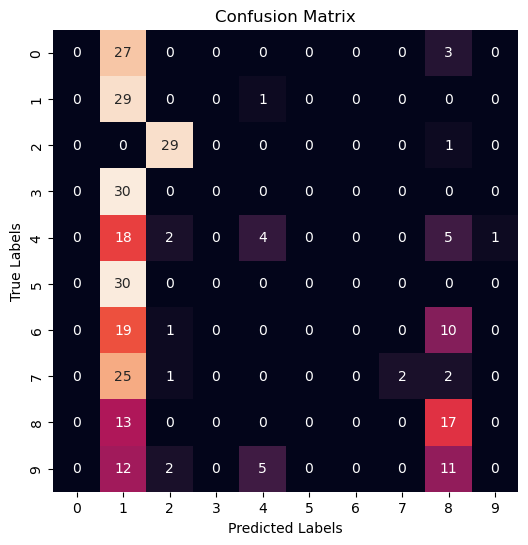

Model trained and tested on 85 samples from each of 20 classes.


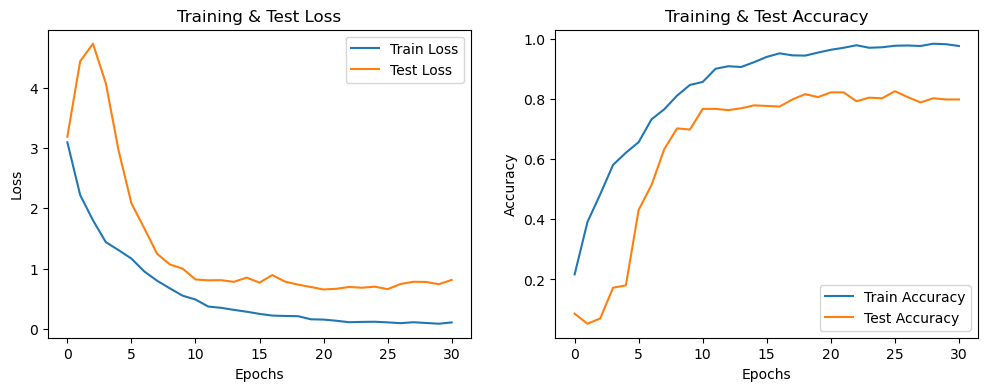

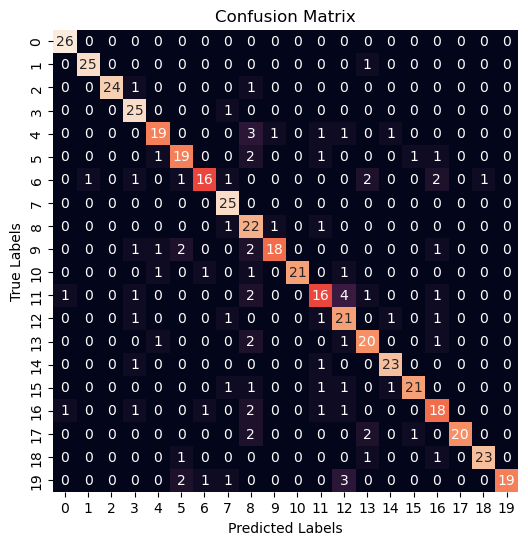

Model trained and tested on 73 samples from each of 30 classes.


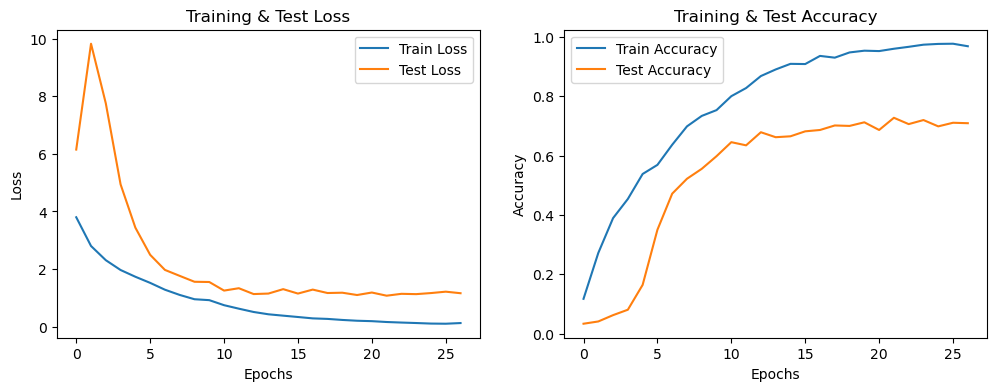

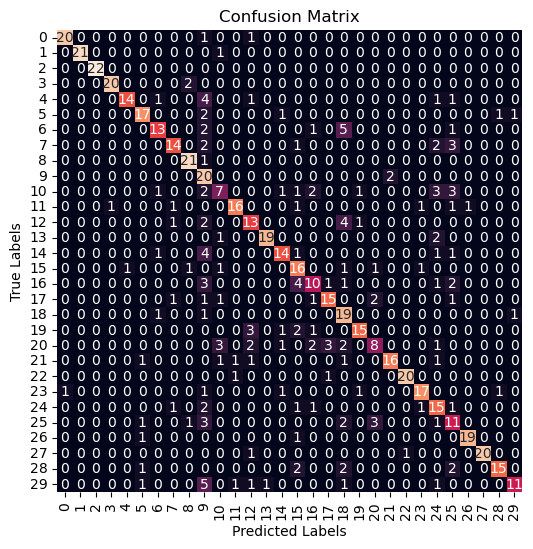

Model trained and tested on 59 samples from each of 50 classes.


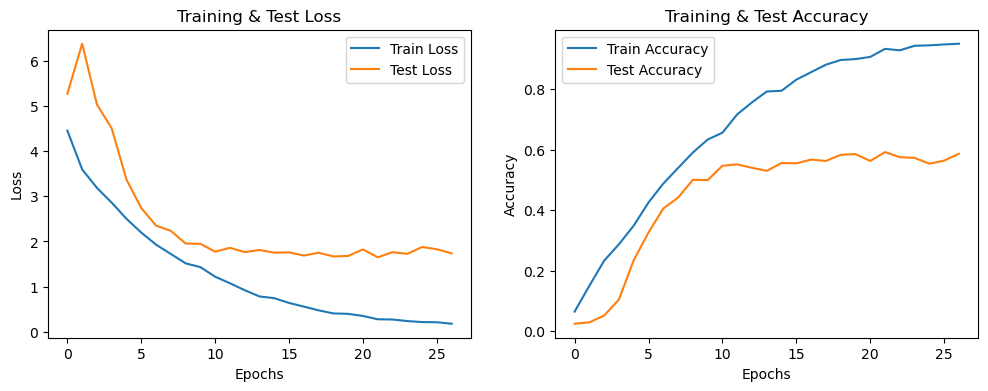

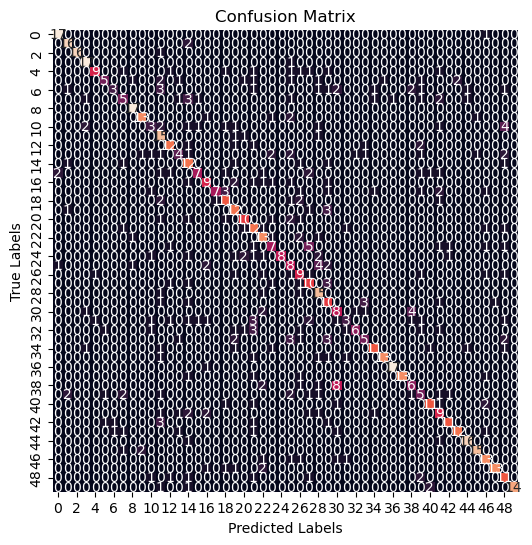

In [43]:
for count, [num_classes, num_samples] in enumerate(zip([10,20,30,50], [100, 85, 73, 59])):
    print(f"Model trained and tested on {num_samples} samples from each of {num_classes} classes.")
    plotLearningCurves(task2_models_values[count])
    conf_matrix = confusionMatrix(task2_true_values[count], task2_pred_values[count])

From the first test of 10 classes we can see that the model is heavily overfitted and does not classify most of the classes correctly except of the first two. This might be caused by the overall complexity of the model, as it is constructed with 3 convolutional blocks, and perhaps a model with fewer parameters would work better. Additionally, smaller amount of data would suffice to train the model to perform well on train and better on test sets. 

Further on, we see that the model performs relatively well from 20 classes up to 50. What is important to note, is that the accuracy slowly deteriorates, as more and more classes are added, but the amount of samples per each class is smaller and smaller, thus making it more difficult for the model to train. 

This issue could be fixed by simply removing the function that preprocesses the dataset so that only equal number of samples from each class is left.That would remove this issue, but another problem would arise. Model would then be strongly biased towards the classes that had the most examples. It would mean that the model would work extremely well only on specified classes, while would struggle to classify any other classes that had smaller amount of samples. 

This exercise visualized very well the model complexity - data amount - classes amount trade-off. It shows that if the model is complex and the number of classes is small, then a very small dataset would be good. On the contrary, at some pointr of classes growth, either the complexity of the model or the dataset size should also grow to maintain the same accuracy. Importantly, making the dataset bigger is far more stable than changing the model architecture, as changes in model architecture are volatile and may not always lead to improved performance, but instead, create a model that works worse for any amount of classes. Therefore, it is preferred to change the dataset size for safer and more convincing results. Additionally, it would be perfect if the dataset was expanded with examples that are diverse and are not similar to examples already in the dataset.

### Compare the models for different preprocessing approaches:
- Raw data - $X$
- Subtracting the mean ($X - \mu$)
- Normalization ($\frac{X - min}{max - min}$)
- Standardization ($\frac{X - \mu}{\sigma}$)

First let us define definitions for each preprocessing approach except the raw data for obvious reasons and standarization as it has been done already.

In [44]:
def rawImages(X_train, X_test):
    return X_train, X_test, 0, 0

def subtractMeanImages(X_train, X_test):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    channel_means = np.mean(X_train_out, axis=(0, 1, 2))
    X_train_out = X_train_out - channel_means
    X_test_out = X_test_out - channel_means
    return X_train_out, X_test_out, channel_means, 0


def normalizeImages(X_train, X_test):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    channel_mins = np.min(X_train_out, axis=(0, 1, 2))
    channel_maxes = np.max(X_train_out, axis=(0, 1, 2))
    X_train_out = (X_train_out - channel_mins) / (channel_maxes - channel_mins)
    X_test_out = (X_test_out - channel_mins) / (channel_maxes - channel_mins)
    return X_train_out, X_test_out, channel_mins, channel_maxes

Now let us create models for each of the methods as well as fit them to the data and predict test values. We will perform the analysis on the basic problem schema, meaning that there will be 20 classes and all other preprocessing will stay the same.

In [45]:
data_x_task3, data_y_task3 = removeClassesNotInList(unique_labels_part2, sorted_indices_part2, data_x_part2, data_y_part2)
data_x_task3, data_y_task3 = cappingClassSize(unique_labels_part2, label_counts_part2, sorted_indices_part2, max_examples_part2, data_x_task3, data_y_task3)
X_train_task3, X_test_task3, y_train_task3, y_test_task3 = train_test_split(data_x_task3, data_y_task3, train_size=0.7, test_size=0.3, stratify=data_y_task3, random_state=24)
X_train_task3, X_test_task3, y_train_task3, y_test_task3, label_encoder_task3 = oneHotEncoding(X_train_task3, X_test_task3, y_train_task3, y_test_task3)

task3_models_values = []
task3_pred_values = []
for method in [rawImages, subtractMeanImages, normalizeImages, standardizeImages]:
    X_train_task3_loop, X_test_task3_loop, _, _ = method(X_train_task3, X_test_task3)
    model_part2_task3 = createModel((64,64,3), 20)
    model_part2_task3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    start = time.perf_counter()
    model_values_part3_loop = model_part2_task3.fit(X_train_task3_loop, y_train_task3, epochs=250, batch_size=32, validation_data=(X_test_task3_loop, y_test_task3), callbacks=[early_stopping], verbose=0)
    task3_pred_loop = model_part2_task3.predict(X_test_task3_loop)
    stop = time.perf_counter()
    task3_models_values.append(model_values_part3_loop)
    task3_classes_loop = np.argmax(task3_pred_loop, axis=1)
    task3_pred_values.append(task3_classes_loop)
    print(f"{str(method)} done after {stop - start:0.5f}")

<function rawImages at 0x00000250E4775CA0> done after 8.33023
<function subtractMeanImages at 0x00000250E4775C10> done after 4.68555
<function normalizeImages at 0x00000250E4775B80> done after 6.56774
<function standardizeImages at 0x0000024F1A1ACF70> done after 10.32262


Now let us see the visualization of the results.

Model trained and tested on images that were raw.


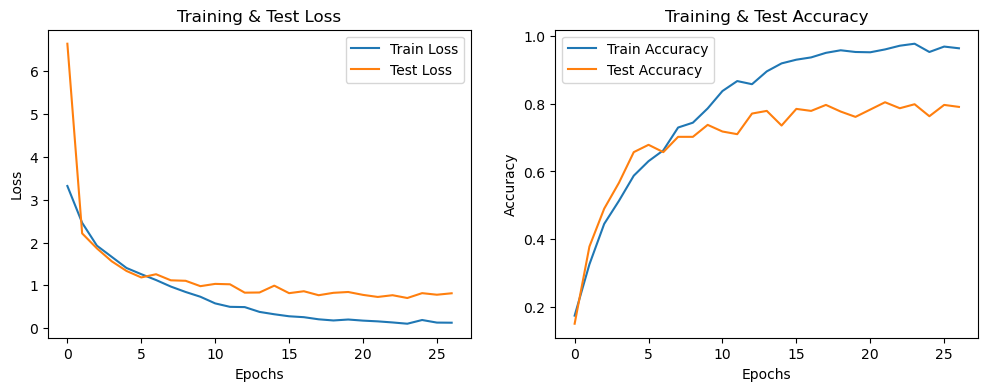

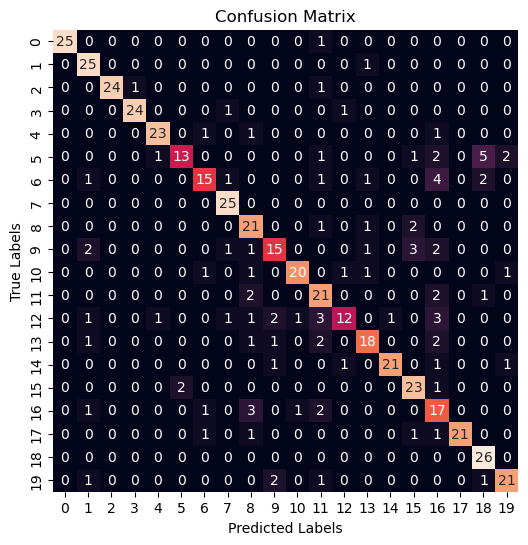

Model trained and tested on images that were subtracted by mean value.


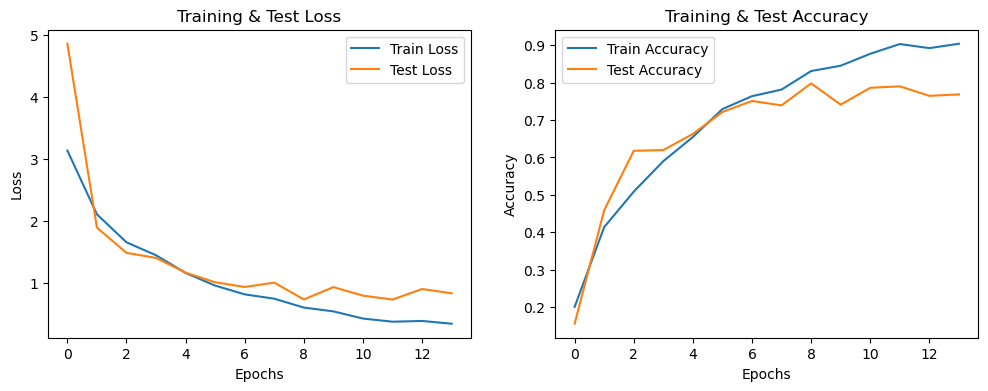

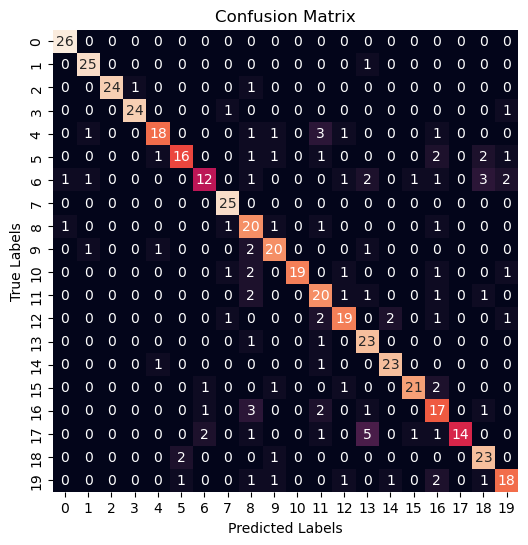

Model trained and tested on images that were normalized.


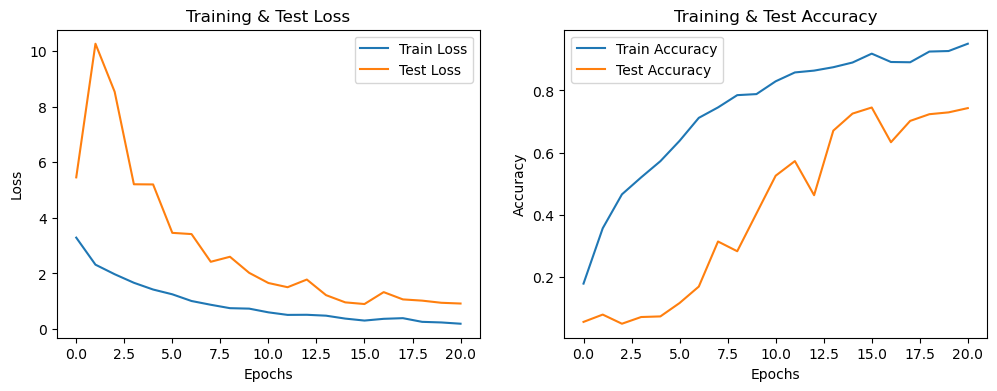

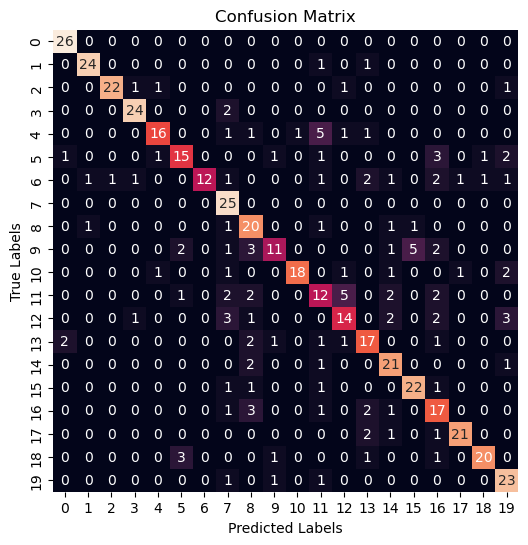

Model trained and tested on images that were standardized.


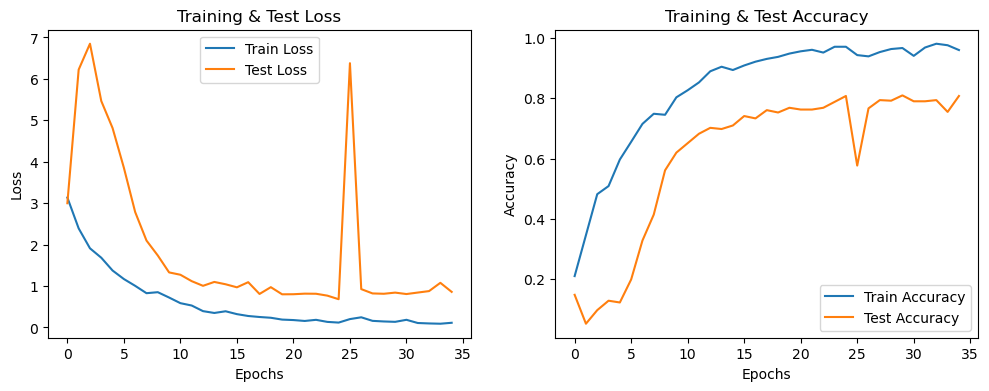

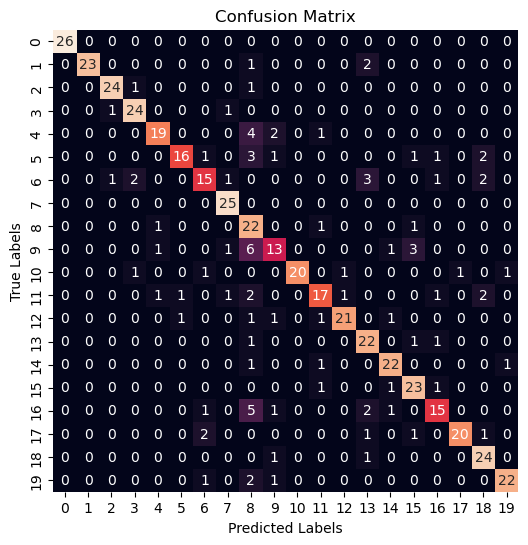

In [46]:
task3_true_values = np.argmax(y_test_task3, axis=1)

for count, method in enumerate(['raw', 'subtracted by mean value', 'normalized', 'standardized']):
    print(f"Model trained and tested on images that were {method}.")
    plotLearningCurves(task3_models_values[count])
    conf_matrix = confusionMatrix(task3_true_values, task3_pred_values[count])

Here we can notice the end results of models' accuracies are pretty much the same, but the line graphs show that these methods trongly vary in number of epochs before being stopped.

Raw image data is able to produce relatively good results considering that no preprocessing was applied. Despite that, the produced results are the worst of all the preprocessing data. The model may find it difficult to generalize and to perform well for data that is different a lot to the training set. To sum up this method, worked fast in this case, but it may not always happen, as the results are strongly dependent on the training set and test set. The accuracies can be high and number of epochs can be low for dataset that contains similar images, but if the dataset would contain diverse data, this method would struggle a lot.  

Subtracting the mean value from the channels of images worked similarily to the normalization method. Both of these methods in the end had high accuracy and were able to get decent results in relatively small number of epochs. The only difference is that the subtraction was able to receive very high results much faster than any other preprocessing method, but than stay more or less on the same level. 

Both normalization and standarization worked well, and contrarary to the substraction, they required larger number of epochs to generate relatively good results. Furthermore, both normalization and standarization seemed to performed better than the other two options in terms of number and size of fluctuations of measures between epochs. What is more, standarization took the largest amount of epochs, but that is purely by chance as the model in Part1 which is exactly equal to this one, finished on average in about 28 epochs. 

Additonally, standarization achieved relatively high accuracy faster than the normalization. 

To sum up, the choice of a preprocessing method is strongly dependent on the dataset, and while it may not change the results to much in this case, it can allow us to save a lot of computational power when chosen correctly, with the correct stopping condition. Additionally, dependent on the dataset, the accuracy measure for given preprocessing method may strongly vary if the unseen images are strongly different to any other images previously seen in terms of colors. 

## Creators
* Kajetan Sulwiński (ekohachi22)
* Mikołaj Marmurowicz (Mickeyo0o)